In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Plot effect of horizons without delays

In [2]:
horizon_seq = np.arange(3, 13, 3)

In [3]:
horizon_seq

array([ 3,  6,  9, 12])

In [4]:
mu_mean_for_horizons = np.array([4.545195, 5.283811, 6.142676, 7.141402])
lower_hpdi_for_horizons = np.array([4.448408, 5.190747, 6.03884, 6.988372])
upper_hpdi_for_horizons = np.array([4.650868, 5.373768, 6.24241, 7.285237])
lower_pi_for_horizons = np.array([2.749181, 3.326895, 4.097161, 4.853865])
upper_pi_for_horizons = np.array([6.697974, 7.513871, 8.700671, 9.783982])

In [5]:
mu_mean_for_horizons_with_delay = np.array([5.878092, 6.833292, 7.943998, 9.235573])
lower_hpdi_for_horizons_with_delay = np.array([5.737804, 6.710696, 7.804641, 9.048578])
upper_hpdi_for_horizons_with_delay = np.array([6.010301, 6.954549, 8.070342, 9.430417])
lower_pi_for_horizons_with_delay = np.array([3.810111, 4.575272, 5.482746, 6.596603])
upper_pi_for_horizons_with_delay = np.array([8.312223, 9.465840, 10.698692, 12.167743])

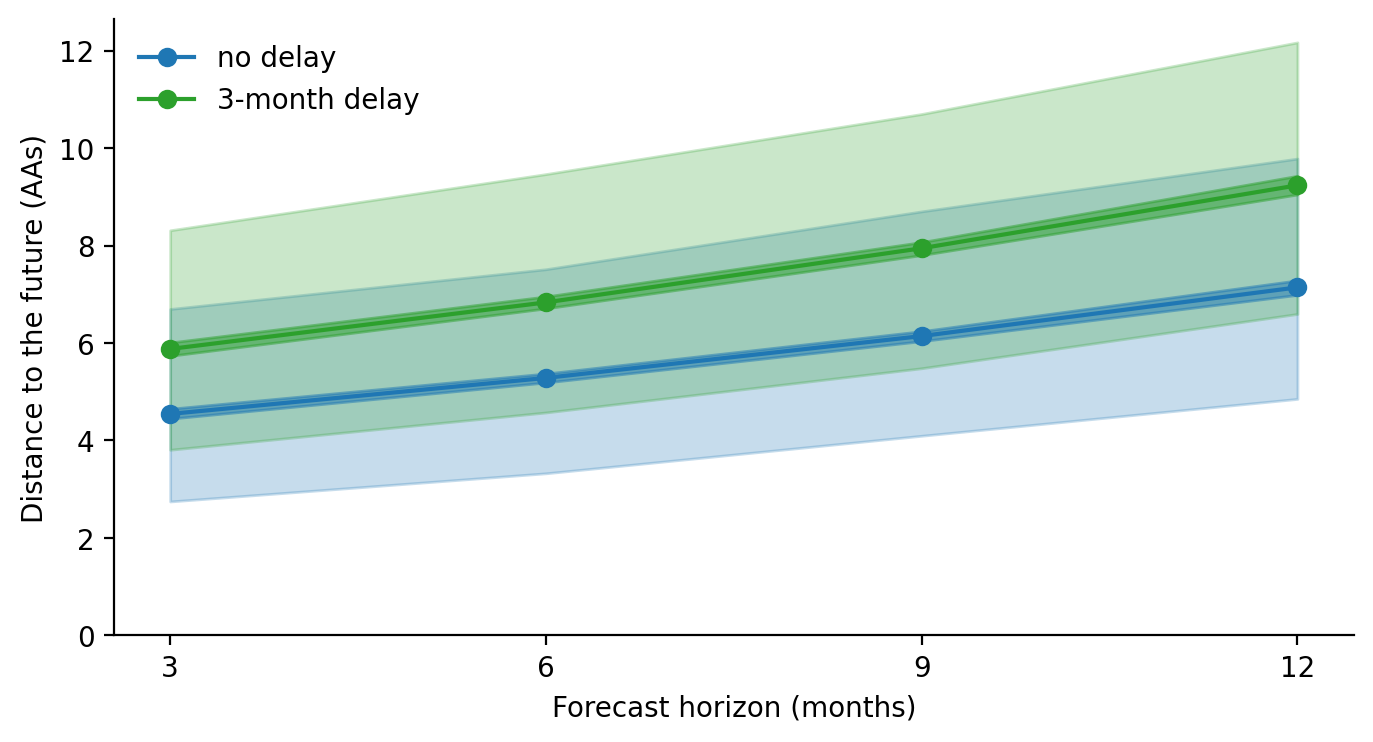

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

# Distance to the future without delay
ax.plot(
    horizon_seq,
    mu_mean_for_horizons,
    "o-",
    color="C0",
    label="no delay",
)

ax.fill_between(
    horizon_seq,
    y1=lower_hpdi_for_horizons,
    y2=upper_hpdi_for_horizons,
    color="C0",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    horizon_seq,
    y1=lower_pi_for_horizons,
    y2=upper_pi_for_horizons,
    color="C0",
    alpha=0.25,
    zorder=-20
)

# Distance to the future with delay
ax.plot(
    horizon_seq,
    mu_mean_for_horizons_with_delay,
    "o-",
    color="C2",
    label="3-month delay",
)

ax.fill_between(
    horizon_seq,
    y1=lower_hpdi_for_horizons_with_delay,
    y2=upper_hpdi_for_horizons_with_delay,
    color="C2",
    alpha=0.5,
    zorder=-10
)

ax.fill_between(
    horizon_seq,
    y1=lower_pi_for_horizons_with_delay,
    y2=upper_pi_for_horizons_with_delay,
    color="C2",
    alpha=0.25,
    zorder=-20
)

ax.set_xticks(horizon_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Forecast horizon (months)")
ax.set_ylabel("Distance to the future (AAs)")

ax.legend(
    loc="upper left",
    frameon=False,
)

sns.despine()

## Plot effect of delays on distance to present

In [7]:
delay_seq = np.arange(0, 4)

In [8]:
delay_seq

array([0, 1, 2, 3])

In [9]:
mu_mean_for_delays = np.array([3.909969, 4.259808, 4.641073, 5.056597])

In [10]:
lower_hpdi = np.array([3.792366, 4.137034, 4.507715, 4.911256])

In [11]:
upper_hpdi = np.array([4.025302, 4.374614, 4.766872, 5.218927])

In [12]:
lower_pi = np.array([2.257030, 2.535537, 2.787971, 3.150549])

In [13]:
upper_pi = np.array([5.861542, 6.326692, 6.802411, 7.259296])

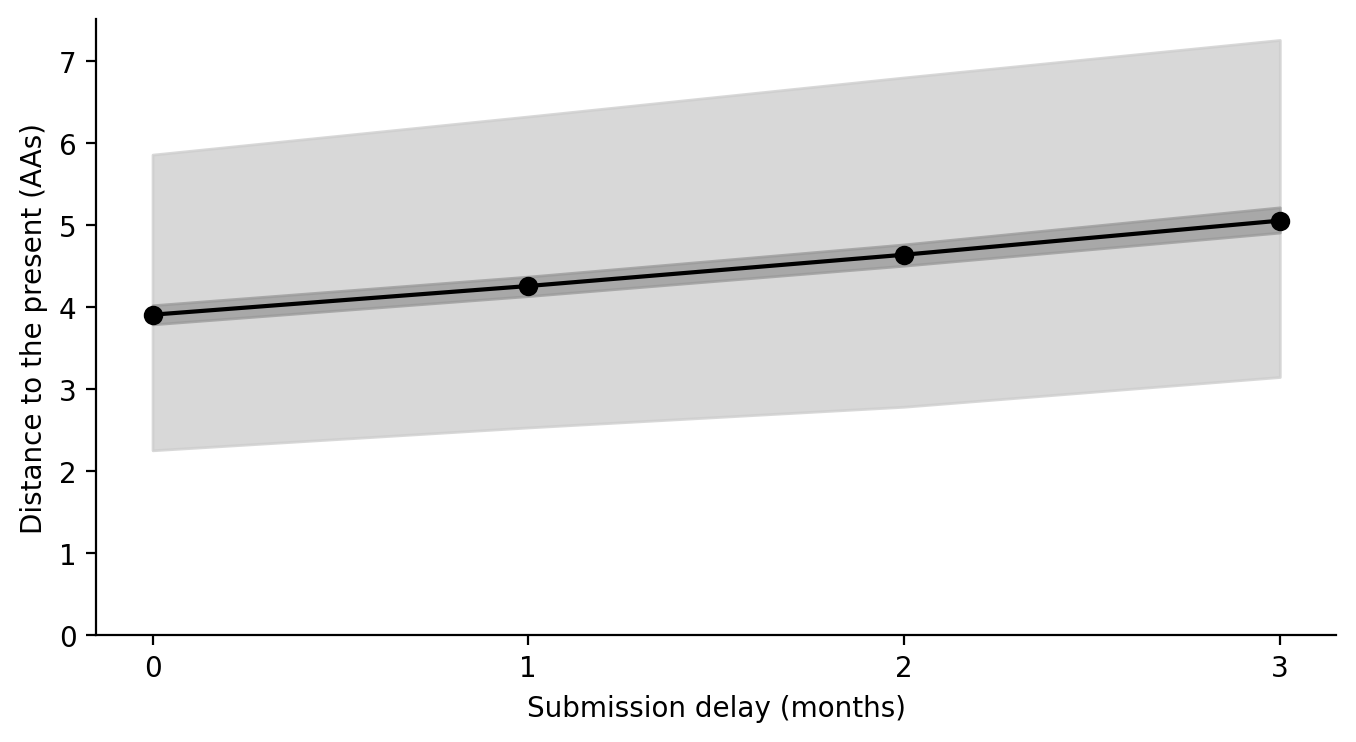

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=200)

ax.plot(
    delay_seq,
    mu_mean_for_delays,
    "o-",
    color="#000000",
)

ax.fill_between(
    delay_seq,
    y1=lower_hpdi,
    y2=upper_hpdi,
    color="#999999",
    alpha=0.75,
    zorder=-10
)

ax.fill_between(
    delay_seq,
    y1=lower_pi,
    y2=upper_pi,
    color="#CCCCCC",
    alpha=0.75,
    zorder=-20
)

ax.set_xticks(delay_seq)

ax.set_ylim(bottom=0)

ax.set_xlabel("Submission delay (months)")
ax.set_ylabel("Distance to the present (AAs)")

sns.despine()

In [26]:
ax.get_xticklabels()

[Text(-0.5, 0, '−0.5'),
 Text(0.0, 0, '0.0'),
 Text(0.5, 0, '0.5'),
 Text(1.0, 0, '1.0'),
 Text(1.5, 0, '1.5'),
 Text(2.0, 0, '2.0'),
 Text(2.5, 0, '2.5'),
 Text(3.0, 0, '3.0'),
 Text(3.5, 0, '3.5')]